In [37]:
import numpy as np
import os
import tifffile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from sklearn.ensemble import RandomForestClassifier

## Load in the images and generate the training data

In [62]:
data_dir = "classifier_data/"
image_dir = data_dir + "sentinel_raster_maps/"
target_dir = data_dir + "target_raster_maps/"

no_images = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(image_dir))))
    
no_targets = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(target_dir))))

assert no_images == no_targets

no_images-=1
no_targets-=1

images = []
targets = []

shp = tifffile.imread("{}image_{}.tiff".format(image_dir, "0")).shape
tilesize = shp[0]
no_bands = shp[2]

X = np.empty((tilesize**2*no_images, no_bands))
y = np.empty(tilesize**2*no_images)

for i in range(no_images):
    #Sentinel band (image) raster - X
    image_data = tifffile.imread("{}image_{}.tiff".format(image_dir, i))
    images.append(image_data)
    
    X[i*tilesize**2:(i+1)*tilesize**2, :] = np.reshape(image_data, (tilesize**2, no_bands))
    
    #Target raster - y
    target = Image.open("{}target_{}.tiff".format(target_dir, i))
    #print(np.array(target.getdata()).shape)
    targets.append(np.reshape(list(target.getdata()), (tilesize, tilesize)))
    
    y[i*tilesize**2:(i+1)*tilesize**2] = np.array(target.getdata())
    
y = y.astype(int)
    
print(X.shape)
print(y.shape)

(20480, 10)
(20480,)


## Plot some samples

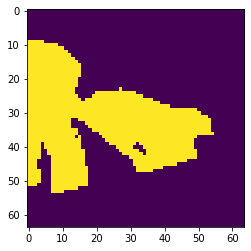

In [63]:
a_target = Image.open('{}/target_5.tiff'.format(target_dir)) #tifffile complains about codecs if you try to use that here
target_pixel_data = np.reshape(list(a_target.getdata()), (64,64))
plt.imshow(target_pixel_data)

(64, 64, 10)


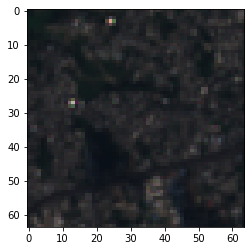

In [64]:
a_image = tifffile.imread('{}/image_5.tiff'.format(image_dir))
print(a_image.shape)
image_pixel_data = a_image[:,:,0:3] #RGB Selected as bands 1:3
plt.imshow(image_pixel_data)

## Train a random forest classifier

In [91]:
rf_classifier = RandomForestClassifier(random_state = 0)
rf_classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [92]:
test_image = np.array(tifffile.imread('{}/image_5.tiff'.format(image_dir)))
test_X = np.reshape(test_image, (tilesize**2, no_bands))
test_y = rf_classifier.predict_log_proba(test_X)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


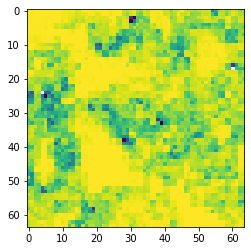

In [93]:
test_target_out = np.reshape(test_y, (tilesize, tilesize, 2))
plt.imshow(test_target_out[:,:,0])

In [94]:
test_y

array([[-0.01005034, -4.60517019],
       [-0.07257069, -2.65926004],
       [-0.01005034, -4.60517019],
       ...,
       [-0.15082289, -1.96611286],
       [-0.0618754 , -2.81341072],
       [-0.30110509, -1.34707365]])